Iantsa Provost & Bastien Soucasse — AMIP

# Assignment 1: Image Similarity

## Subject

### Objectives

The goal of this assignment is to implement similarity metrics, and to apply them to images, patches or features and observe their influence. You will be evaluated on these objectives, the quality of your explanations, and the results analysis.

### Instructions

Explanations can be written either in this notebook or in a side report. In both cases, captions must be added to every figure or table, results must be full analyzed, references added if needed.

### Question 1: Similarity Metrics

Write **and comment** some functions to compute similarities between multi-dimensional arrays or tensors. You must implement at least the following:

- Manhattan Distance (L1).
- Euclidean Distance (L2).
- Zero-mean Normalized Cross-Correlation (ZNCC).
- Peak Signal-to-Noise Ratio (PSNR).
- Structural Similarity Index Measure (SSIM). You can use here sklearn or pytorch libraries that implement ssim_method, but if you do so, add some explanations on SSIM computation.
- Perceptual Losses (see code samples below):
    - Reconstruction Loss[1] (using pretrained VGG networks).
    - Style Reconstruction Loss[1] (using pretrained VGG networks).
    - lpips [2].

**Remark:** You will be evaluated both on codes and on explanations of the metric (here or in the report).

**Code sample for computing features at certain layers with pretrained VGG.**

```python
from vgg_models.vgg import get_vgg_net

vgg_net = get_vgg_net()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]),
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1, 1, 1]),
    transforms.Lambda(lambda x: x.mul_(1.)),
])

img = Image.open('data/looksalike/left/00001.jpg').convert('RGB')
img = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    print('CUDA ON')
    img = img.cuda()
feats = vgg_net(img)

for feat in feats:
    print(feat.detach().cpu().size())
```

**Code sample for using lpips.**

```python
import lpips

transform = transforms.ToTensor()
img1 = transform(Image.open('data/looksalike/left/00001.jpg').convert('RGB'))
img2 = transform(Image.open('data/looksalike/right/00001.jpg').convert('RGB'))
loss_fn = lpips.LPIPS(net='alex', lpips=True)

d = loss_fn.forward(img1, img2)

print('LPIPS value is %.2f \n' % d)
```

### Question 2: Evaluation

The folder `looksalike` provides a very small sample of the <a href='https://www.kaggle.com/datasets/ruchi798/totally-looks-like-dataset'>Totally Looks Like Dataset</a> [3]. Use the different metrics to evaluate if pairs of images match or not. Analyse the results. You are free to use other images to evaluate the metrics.

### Question 3: Robustness

Evaluate the robustness of the metrics to different transformation (noise, rotation, luminosity changes…).

### References 

[1] Johnson, Alahi, Fei-Fei, Perceptual losses for real-time style transfer and super-resolution, In ECCV, 2016.

[2] Zhang, Isola, Efros, Shechtman, Wang. The Unreasonable Effectiveness of Deep Features as a Perceptual Metric. In CVPR, 2018.

[3] Amir Rosenfeld, Markus Solbach, John Tsotsos; Totally-Looks-Like: A Dataset and Benchmark of Semantic Image Similarity. Journal of Vision 2018.

## Introduction

First, let’s import all major libraries, and declare useful utility functions to help us.

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms

In [2]:
def image_to_tensor(image, device=torch.device('cpu')):
    '''Converts an image into a tensor (onto a device if specified).'''
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])]),
        transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], std=[1, 1, 1]),
        transforms.Lambda(lambda x: x.mul_(255)),
    ])

    return transform(image).unsqueeze(0).to(device)


def tensor_to_image(tensor):
    '''Converts a tensor into an image.'''
    transform = transforms.Compose([
        transforms.Lambda(lambda x: x.mul_(1. / 255.)),
        transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], std=[1, 1, 1]),
        transforms.Lambda(lambda x: x[torch.LongTensor([2, 1, 0])])
    ])

    tmp = transform(tensor.squeeze(0))
    tmp[tmp > 1] = 1
    tmp[tmp < 0] = 0

    transform = transforms.Compose([
        transforms.ToPILImage()
    ])

    return transform(tmp)


def display_image(image, size=(4, 4)):
    '''Visualizes an image.'''
    plt.figure(figsize=size)
    plt.imshow(image)
    plt.axis('off')
    plt.show()


def display_images(images, size=(8, 4)):
    '''Visualizes an image list.'''
    fig = plt.figure(figsize=size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()


def gram_matrix(input):
    '''Computes a Gram matrix.'''
    b, d, h, w = input.size()
    features = input.view(d, h * w)
    gramm = torch.mm(features, features.t())
    return gramm.div(b * d * h * w)

Now we can set up the device used by PyTorch for training and testing NN models.

In [3]:
if torch.__version__ < '1.12':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')  # type: ignore
print(f'Using device: {device.type}.')

Using device: mps.


## Question 1: Similarity Metrics

First, we need to set up the images data used for the tests.

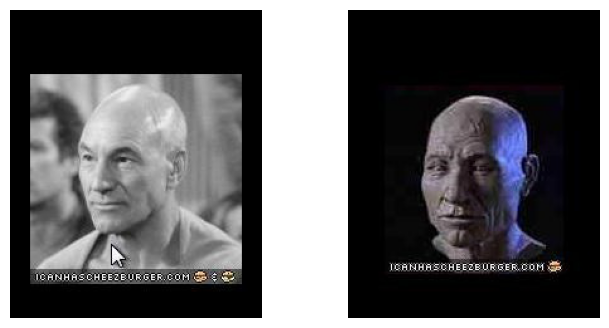

In [4]:
# Images
img1, img2 = Image.open('data/looksalike/left/00006.jpg').convert('RGB'), Image.open('data/looksalike/right/00006.jpg').convert('RGB')

# Plot Images
display_images([img1, img2])

# PyTorch Version
tensor1, tensor2 = image_to_tensor(img1, device), image_to_tensor(img2, device)

# Numpy Version
img1, img2 = np.array(img1), np.array(img2)

### Manhattan Distance (L1)

In [5]:
def l1(img1, img2):
    assert(img1.shape == img2.shape)
    return np.sum(np.abs(img1 - img2))


l1(img1, img2)

10140536

The L1 norm is quite big, but it’s legit since it’s not “direct”. (Since we have no value range, it can't be used by itself to determine images correlation.)

### Euclidian Distance (L2)

In [6]:
def l2(img1, img2):
    assert(img1.shape == img2.shape)
    return np.sqrt(np.sum(np.square(img1 - img2)))


l2(img1, img2)

2961.8801461234043

The L2 norm is a lot smaller than the L1 one, as expected. (Like before, since we have no value range, it can't be used by itself to determine images correlation.)

### Zero-Normalized Cross-Correlation (ZNCC)

In [7]:
def zncc(img1, img2):
    assert(img1.shape == img2.shape)
    return 1 - np.sum((img1 - np.mean(img1)) * (img2 - np.mean(img2))) / np.sqrt(np.sum(np.square(img1 - np.mean(img1))) * np.sum(np.square(img2 - np.mean(img2))))


zncc(img1, img2)

0.5446837222853157

The ZNCC is a number between 0 and 1. With this formula, the lower the more correlated the images. Here, we have a ZNCC value of 0.54 so the images seem a bit correlated. Later, we will compare this value for different couples.

### Peak Signal-to-Noise Ratio (PSNR)

This code is based on our earlier implementation of PSNR with MSE, for the first assignment of Deep Learning for Computer Vision (DLCV).

In [8]:
def compute_mse(img1, img2):
    h, w = img1.shape[:2]
    return np.sum(np.square(img1.astype(np.int32) - img2.astype(np.int32))) / (h * w)


def psnr(img1, img2):
    assert(img1.shape == img2.shape)
    mse = compute_mse(img1, img2)
    if mse <= 0:
        return 0
    return 10 * np.log10(np.square(255) / mse)


psnr(img1, img2)

4.23582544365038

The PSNR represents the fluctuation of the signal, so the lower the better. (We can’t say yet if this value is good or not.)

### SSIM

This code is using a library: [pytorch-msssim](https://github.com/VainF/pytorch-msssim).

In [9]:
import pytorch_msssim


def alt_ssim(tensor1, tensor2):
    assert(tensor1.shape == tensor2.shape)
    tensor1, tensor2 = tensor1[None, :], tensor2[None, :]

    # Module pytorch_msssim is not compatible with device mps.
    if (device.type == 'mps'):
        tensor1, tensor2 = tensor1.cpu(), tensor2.cpu()
    
    ssim = pytorch_msssim.ssim(tensor1, tensor2, data_range=255, size_average=False).item()
    return 1 - ssim


alt_ssim(tensor1, tensor2)

/Users/bastiensoucasse/Developer/AMIP/td1-similarity/pytorch_msssim/ssim.py:50: UserWarning: Skipping Gaussian Smoothing at dimension 2+0 for input: torch.Size([1, 1, 3, 245, 200]) and win size: 11
  warnings.warn(


0.7241390943527222

The SSIM is a number between 0 and 1 reprensenting the correlation ratio of the two images (so the higher the better). But, for better testing and to keep consistency with all the other versions, we take this value off 1 to be able to find the minimum. In other words, with our final function `inv_ssim`, a value of 0.72 is equivalent to 28% of correlation given by `pytorch_msssim.ssim`.

### Perceptual Losses

First, let’s initialize our VGG model.

In [10]:
import lpips as LPIPS
from vgg_models import vgg as VGG

vgg = VGG.get_vgg_net().to(device)
lpips = LPIPS.LPIPS(net='alex', lpips=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/homebrew/Caskroom/miniconda/base/envs/deep-learning/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/deep-learning/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/bastiensoucasse/Developer/AMIP/td1-similarity/lpips/weights/v0.1/alex.pth


#### Feature Reconstruction Loss

In [11]:
def feature_reconstruction_loss(tensor1, tensor2):
    features1, features2 = vgg(tensor1), vgg(tensor2)
    loss = np.empty(len(features1))
    for i in range(len(features1)):
        loss[i] = torch.nn.MSELoss()(features1[i], features2[i]).item()
    return np.sum(loss)


feature_reconstruction_loss(tensor1, tensor2)

169367.279296875

The Feature Reconstruction Loss shows the degree of similarities between the features extracted from the images. (As we have no value range, we can't use the value as is to interprete the degree of similarity, we need to compare different samples.)

#### Style Reconstruction Loss

In [12]:
def style_reconstruction_loss(tensor1, tensor2):
    features1, features2 = vgg(tensor1), vgg(tensor2)
    gram1, gram2 = [gram_matrix(f) for f in features1], [gram_matrix(f) for f in features2]
    loss = np.empty(len(features1))
    for i in range(len(features1)):
        loss[i] = torch.nn.MSELoss()(gram1[i], gram2[i]).detach().item()
    return np.sum(loss)


style_reconstruction_loss(tensor1, tensor2)

12465.743438974023

Similarly to the feature one, the Style Reconstruction Loss represents the style similarity between the two images, by computing the loss between the Gram matrices of the features. (Like before, we can't analyse the value by itself.)

#### LPIPS

In [13]:
def lpips_loss(tensor1, tensor2):
    return lpips.to(device)(tensor1, tensor2).detach().item()


lpips_loss(tensor1, tensor2)

0.5069479942321777

The LPIPS loss is a value between 0 and 1. The images here seem barely correlated. Now we have to evaluate this metric and all the other ones.

## Question 2: Evaluation

### Phase 1

First of all, we can compute the metrics for each couple and get a preview of the similarity of their images.

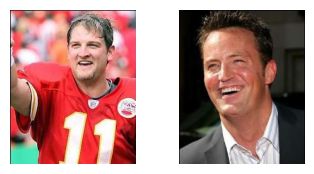

0000:
    - l1: 18990415.
    - l2: 3932.6348673631014.
    - zncc: 0.7825129904380164.
    - psnr: 2.2863277497164294.
    - ssim: 0.9747730139642954.
    - feature_reconstruction_loss: 432981.5881347656.
    - style_reconstruction_loss: 77399.34670054913.
    - lpips: 0.7220475673675537.

 ——————————————————————————————————————————


/Users/bastiensoucasse/Developer/AMIP/td1-similarity/pytorch_msssim/ssim.py:50: UserWarning: Skipping Gaussian Smoothing at dimension 2+0 for input: torch.Size([1, 1, 3, 245, 200]) and win size: 11
  warnings.warn(


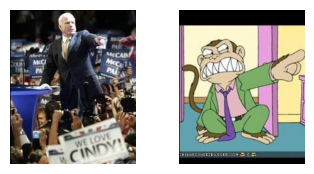

0001:
    - l1: 16606918.
    - l2: 3890.80582913103.
    - zncc: 1.0074410840209274.
    - psnr: 1.5001047299473427.
    - ssim: 1.0062393774278462.
    - feature_reconstruction_loss: 378998.91760253906.
    - style_reconstruction_loss: 24069.300956845284.
    - lpips: 0.6747833490371704.

 ——————————————————————————————————————————


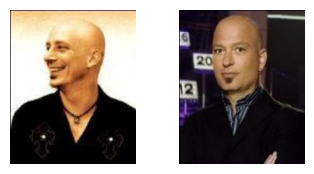

0002:
    - l1: 25739308.
    - l2: 3796.133032442356.
    - zncc: 0.6433452921391516.
    - psnr: 1.0885979608931005.
    - ssim: 0.9080072194337845.
    - feature_reconstruction_loss: 236522.24243164062.
    - style_reconstruction_loss: 17308.97121220827.
    - lpips: 0.5925043821334839.

 ——————————————————————————————————————————


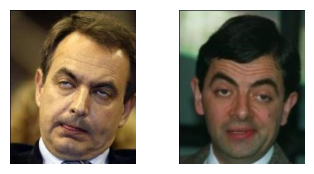

0003:
    - l1: 15283362.
    - l2: 3914.327272980633.
    - zncc: 0.9376763822218803.
    - psnr: 5.074466812148363.
    - ssim: 0.9320065900683403.
    - feature_reconstruction_loss: 165398.2049560547.
    - style_reconstruction_loss: 5285.849686697125.
    - lpips: 0.5890706777572632.

 ——————————————————————————————————————————


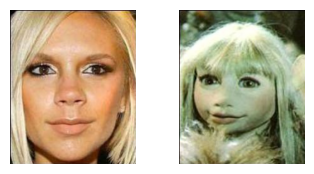

0004:
    - l1: 18820211.
    - l2: 3942.945218995567.
    - zncc: 0.7410446655271762.
    - psnr: 5.807987160715699.
    - ssim: 0.8998374491930008.
    - feature_reconstruction_loss: 198633.90270996094.
    - style_reconstruction_loss: 11340.938104867935.
    - lpips: 0.5643520355224609.

 ——————————————————————————————————————————


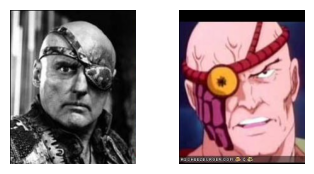

0005:
    - l1: 18027223.
    - l2: 3878.771068263761.
    - zncc: 0.9367142014974914.
    - psnr: 1.9624319384940312.
    - ssim: 0.9791288208216429.
    - feature_reconstruction_loss: 358631.6965332031.
    - style_reconstruction_loss: 39836.69774109125.
    - lpips: 0.6645652055740356.

 ——————————————————————————————————————————


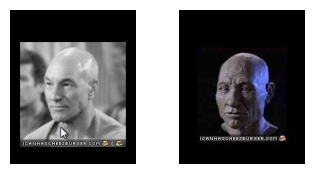

0006:
    - l1: 10140536.
    - l2: 2961.8801461234043.
    - zncc: 0.5446837222853157.
    - psnr: 4.23582544365038.
    - ssim: 0.7241390943527222.
    - feature_reconstruction_loss: 169367.279296875.
    - style_reconstruction_loss: 12465.743438974023.
    - lpips: 0.5069479942321777.

 ——————————————————————————————————————————


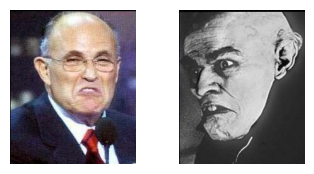

0007:
    - l1: 20585148.
    - l2: 3859.164158208355.
    - zncc: 0.4287618778933703.
    - psnr: 6.789150423552755.
    - ssim: 0.7979540377855301.
    - feature_reconstruction_loss: 204033.3251953125.
    - style_reconstruction_loss: 13308.9818649292.
    - lpips: 0.5285727977752686.


In [14]:
for i in range(0, 8):
    if i != 0:
        print('\n', '—' * 42)

    # Open (and display) images.
    img1, img2 = Image.open('data/looksalike/left/0000%d.jpg' % i).convert('RGB'), Image.open('data/looksalike/right/0000%d.jpg' % i).convert('RGB')
    display_images([img1, img2], size=(4, 2))

    # Convert to tensor.
    tensor1, tensor2 = image_to_tensor(img1, device), image_to_tensor(img2, device)

    # Convert to multi-dimensional array.
    img1, img2 = np.array(img1), np.array(img2)

    # Display metrics summary.
    print(f'000{i}:')
    print(f'    - l1: {l1(img1, img2)}.')
    print(f'    - l2: {l2(img1, img2)}.')
    print(f'    - zncc: {zncc(img1, img2)}.')
    print(f'    - psnr: {psnr(img1, img2)}.')
    print(f'    - ssim: {alt_ssim(tensor1, tensor2)}.')
    print(f'    - feature_reconstruction_loss: {feature_reconstruction_loss(tensor1, tensor2)}.')
    print(f'    - style_reconstruction_loss: {style_reconstruction_loss(tensor1, tensor2)}.')
    print(f'    - lpips: {lpips_loss(tensor1, tensor2)}.')

L1 and L2 norms are hard to exploit as is but still are a first indication when compared between different couples. They find couple 0006 the most correlated, and couple 0004 the less. It may suggests that L1 and L2 norms may be more able to detect similarity when the position and the dimension of the subject are very close on both images.

The ZNCC values are quite high in general, but by comparing all of them, we find that this method finds couples 0006 and 0007 the most similar, and couple 0001 the less.

The PSNR method gives the best results for couple 0002, and the worst for couple 0007.

Like ZNCC, the SSIM values are also quite high. But when analysing it with the other ones, it also shows that couples 0006 and 007 are the most similar, and couple 0001 the less.

Now, regarding the perceptual losses, we can see that the feature and style reconstruction loss methods both detect couple 0003 as the most similar, and the LPIPS one couple 006.

Now, we can see each method gives very different results. As a consequence, it’s hard to tell which couples are the most similar.

### Phase 2

We have a first preview of the similarities detection for each couple. But to go further, we can check for each left image which right image is the closest found by each method.

In [15]:
# For each one criterion, define the good match detections count.
criterions_np = {'l1': 0, 'l2': 0, 'zncc': 0, 'psnr': 0}
criterions_torch = {'alt_ssim': 0, 'feature_reconstruction_loss': 0, 'style_reconstruction_loss': 0, 'lpips_loss': 0}

# For each couple (pair of images left/right of same id), define the number of times a match has been found.
couples = np.zeros(8, dtype=np.int8)

In [16]:
for i in range(8):
    if i != 0:
        print()
    print(f'left/000{i}:')

    img1_name = 'data/looksalike/left/0000%d.jpg' % i
    img1 = Image.open(img1_name).convert('RGB')
    tensor1 = image_to_tensor(img1, device=device)
    img1 = np.array(img1)

    # Numpy criterions.
    for criterion in criterions_np:
        print(f'    - {criterion}: ', end='')
        losses = np.empty(8)

        for j in range(8):
            img2_name = 'data/looksalike/right/0000%d.jpg' % j
            img2 = np.array(Image.open(img2_name).convert('RGB'))
            losses[j] = eval(criterion + '(img1, img2)')

        correspondance = losses.argmin()
        print(f'right/000{correspondance}', end='')
        if correspondance == i:
            criterions_np[criterion] += 1
            couples[i] += 1
            print(' (PERFECT)', end='')
        print('.')

    # Pytorch criterions.
    for criterion in criterions_torch:
        print(f'    - {criterion}: ', end='')
        losses = np.empty(8)

        for j in range(8):
            img2_name = 'data/looksalike/right/0000%d.jpg' % j
            tensor2 = image_to_tensor(Image.open(img2_name).convert('RGB'), device=device)
            losses[j] = eval(criterion + '(tensor1, tensor2)')

        correspondance = losses.argmin()
        print(f'right/000{correspondance}', end='')
        if correspondance == i:
            criterions_torch[criterion] += 1
            couples[i] += 1
            print(' (PERFECT)', end='')
        print('.')

left/0000:
    - l1: right/0002.
    - l2: right/0006.
    - zncc: right/0005.
    - psnr: right/0006.
    - alt_ssim: right/0005.
    - feature_reconstruction_loss: right/0003.
    - style_reconstruction_loss: right/0005.
    - lpips_loss: right/0005.

left/0001:
    - l1: right/0006.
    - l2: right/0006.
    - zncc: right/0000.
    - psnr: right/0001 (PERFECT).
    - alt_ssim: right/0006.
    - feature_reconstruction_loss: right/0007.
    - style_reconstruction_loss: right/0000.
    - lpips_loss: right/0004.

left/0002:
    - l1: right/0001.
    - l2: right/0006.
    - zncc: right/0002 (PERFECT).
    - psnr: right/0006.
    - alt_ssim: right/0007.
    - feature_reconstruction_loss: right/0002 (PERFECT).
    - style_reconstruction_loss: right/0000.
    - lpips_loss: right/0002 (PERFECT).

left/0003:
    - l1: right/0006.
    - l2: right/0002.
    - zncc: right/0000.
    - psnr: right/0001.
    - alt_ssim: right/0006.
    - feature_reconstruction_loss: right/0003 (PERFECT).
    - styl

In [17]:
print('Criterions Scores:')
for criterions in [criterions_np, criterions_torch]:
    for criterion in criterions:
        print(f'    - {criterion}: {criterions[criterion]}.')

Criterions Scores:
    - l1: 1.
    - l2: 2.
    - zncc: 4.
    - psnr: 2.
    - alt_ssim: 3.
    - feature_reconstruction_loss: 4.
    - style_reconstruction_loss: 1.
    - lpips_loss: 5.


In [18]:
print('Couples Match:')
for i in range(8):
    print(f'    - 000{i}: {couples[i]}.')

Couples Match:
    - 0000: 0.
    - 0001: 1.
    - 0002: 3.
    - 0003: 3.
    - 0004: 3.
    - 0005: 1.
    - 0006: 6.
    - 0007: 5.


The LPIPS method gives very good results on this dataset as it is able to detect the most couples, followed by the ZNCC method and the Feature Reconstruction Loss method, whereas the L1 norm method is the less efficient, along with the Style Recongnition Loss (not surprising since there is no particular style in the images).

Couple 0006 is the most detected, closely followed by couple 0007. Conversely, the images of couple 0000 seem to be the least similar.

## Question 3: Robustness

We are goind to use a single image which we will modify to check the robustness of the different methods.

In [19]:
img = Image.open('data/2018.jpg').convert('RGB')

### Noisy Image

/var/folders/yx/3zcgprn14jb5dw63zzl4q7n80000gn/T/ipykernel_5644/1753669355.py:22: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835428/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  tmp[tmp > 1] = 1


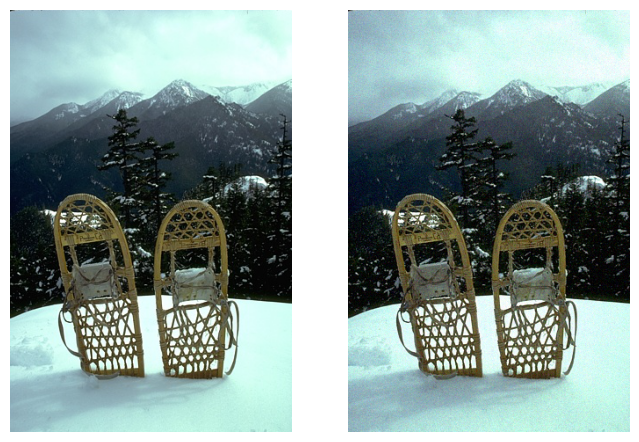

In [20]:
img1 = img
tensor1 = image_to_tensor(img, device=device)

sigma = 1000
tensor2 = tensor1 + 2. / 255. * sigma * torch.randn(tensor1.shape).to(device)
img2 = tensor_to_image(tensor2)

display_images([img1, img2], size=(8, 6))
img1, img2 = np.array(img1), np.array(img2)

In [21]:
print(f'l1: {l1(img1, img2)}.')
print(f'l2: {l2(img1, img2)}.')
print(f'zncc: {zncc(img1, img2)}.')
print(f'psnr: {psnr(img1, img2)}.')
print(f'ssim: {alt_ssim(tensor1, tensor2)}.')
print(f'feature_reconstruction_loss: {feature_reconstruction_loss(tensor1, tensor2)}.')
print(f'style_reconstruction_loss: {style_reconstruction_loss(tensor1, tensor2)}.')
print(f'lpips: {lpips_loss(tensor1, tensor2)}.')

/Users/bastiensoucasse/Developer/AMIP/td1-similarity/pytorch_msssim/ssim.py:50: UserWarning: Skipping Gaussian Smoothing at dimension 2+0 for input: torch.Size([1, 1, 3, 481, 321]) and win size: 11
  warnings.warn(


l1: 50985962.
l2: 4534.144902845519.
zncc: 0.003545759376535451.
psnr: 25.865603640383323.
ssim: 0.9920210018754005.
feature_reconstruction_loss: 184716.71417236328.
style_reconstruction_loss: 31758.64502327144.
lpips: 0.6362703442573547.


### Rotated Image

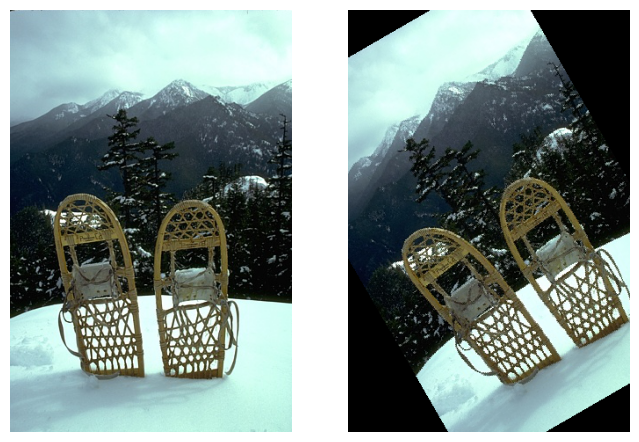

In [22]:
img1 = img
tensor1 = image_to_tensor(img, device=device)

transform = transforms.Compose([
    transforms.RandomRotation((30, 30))
])

img2 = transform(img1)
tensor2 = image_to_tensor(img2, device=device)

display_images([img1, img2], size=(8, 6))
img1, img2 = np.array(img1), np.array(img2)

In [23]:
print(f'l1: {l1(img1, img2)}.')
print(f'l2: {l2(img1, img2)}.')
print(f'zncc: {zncc(img1, img2)}.')
print(f'psnr: {psnr(img1, img2)}.')
print(f'ssim: {alt_ssim(tensor1, tensor2)}.')
print(f'feature_reconstruction_loss: {feature_reconstruction_loss(tensor1, tensor2)}.')
print(f'style_reconstruction_loss: {style_reconstruction_loss(tensor1, tensor2)}.')
print(f'lpips: {lpips_loss(tensor1, tensor2)}.')

l1: 64738666.
l2: 6808.628936871211.
zncc: 0.7268131294791684.
psnr: 2.2110693764097653.
ssim: 0.9194745123386383.
feature_reconstruction_loss: 222607.2452392578.
style_reconstruction_loss: 5073.167662113905.
lpips: 0.5577584505081177.


### Summary

We have seen on the previous dataset that the best methods were LPIPS, ZNCC, and Feature Reconstruction Loss.

We can notice here that LPIPS keeps a good similarity detection for a rotated image, but less for a noisy image. ZNCC is incredibly good at detecting similarities for a noisy image, but not at all for a rotated one. Feature Reconstruction Loss is better on noisy images than rotated images.

The L1 and L2 norms give proportional results. By comparing to previous results, we can see that they are both not very robust. But still, they are better on noisy images than on rotated images.

The PSNR is surprisingly good on rotated images (it’s far from the worst value we’ve had). But on noisy images, the value is extremely high (5 times higher than the worst we’ve had).

Regarding SSIM, the value for a noisy image is a lot higher than the previous ones. So SSIM doesn’t seem very good dealing with two versions of the same image in general.

Finally, the style reconstruction loss is very robust to changes in images. The style of the image is kept after modification. So this is a very good method for comparing two versions of one image.